# 1) PyTorch Geometric (Datasets and Data)


PyTorch Geometric has two classes for storing and/or transforming graphs into tensor format. One is `torch_geometric.datasets`, which contains a variety of common graph datasets. Another is `torch_geometric.data`, which provides the data handling of graphs in PyTorch tensors.

In this section, we will learn how to use `torch_geometric.datasets` and `torch_geometric.data` together.

## PyG Datasets

The `torch_geometric.datasets` class has many common graph datasets. Here we will explore its usage through one example dataset.

In [3]:
import torch_geometric.nn
from torch_geometric.datasets import TUDataset

root = 'enzymes'
name = 'ENZYMES'

# The ENZYMES dataset
pyg_dataset = TUDataset(root, name)

# You will find that there are 600 graphs in this dataset
print(pyg_dataset)

ENZYMES(600)


## Question 1: What is the number of classes and number of features in the ENZYMES dataset?

In [4]:
# TODO: Implement a function that takes a PyG dataset object
# and returns the number of classes for that dataset.
def get_num_classes(pyg_dataset):
    num_classes = pyg_dataset.num_classes

    return num_classes


# TODO: Implement a function that takes a PyG dataset object
# and returns the number of features for that dataset.
def get_num_features(pyg_dataset):
    num_features = pyg_dataset.num_features

    return num_features


num_classes = get_num_classes(pyg_dataset)
num_features = get_num_features(pyg_dataset)
print("{} dataset has {} classes".format(name, num_classes))
print("{} dataset has {} features".format(name, num_features))

ENZYMES dataset has 6 classes
ENZYMES dataset has 3 features


### Answer 1:

ENZYMES dataset has 6 classes

ENZYMES dataset has 3 features

## PyG Data

Each PyG dataset stores a list of `torch_geometric.data.Data` objects, where each `torch_geometric.data.Data` object represents a graph. We can easily get the `Data` object by indexing into the dataset.

For more information such as what is stored in the `Data` object, please refer to the [documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data).


## Question 2: What is the label of the graph with index 100 in the ENZYMES dataset?

In [5]:
# TODO: Implement a function that takes a PyG dataset object,
# an index of a graph within the dataset, and returns the class/label
# of the graph (as an integer).
def get_graph_class(pyg_dataset, idx):
    graph = pyg_dataset[idx]
    label = int(graph.y)

    return label


# Here pyg_dataset is a dataset for graph classification
graph_0 = pyg_dataset[0]
idx = 100
label = get_graph_class(pyg_dataset, idx)
print('Graph with index {} has label {}'.format(idx, label))

Graph with index 100 has label 4


### Answer 2:

Graph with index 100 has label 4

## Question 3: How many edges does the graph with index 200 have?

In [6]:
# TODO: Implement a function that takes a PyG dataset object,
# the index of a graph in the dataset, and returns the number of
# edges in the graph (as an integer). You should not count an edge
# twice if the graph is undirected. For example, in an undirected
# graph G, if two nodes v and u are connected by an edge, this edge
# should only be counted once.
def get_graph_num_edges(pyg_dataset, idx):
    ############# Your code here ############
    ## Note:
    ## 1. You can't return the data.num_edges directly
    ## 2. We assume the graph is undirected
    ## 3. Look at the PyG dataset built in functions
    from torch_geometric.data import Data
    graph: Data = pyg_dataset[idx]
    num_edges = graph.num_edges if graph.is_directed() else graph.num_edges / 2

    #########################################

    return int(num_edges)


idx = 200
num_edges = get_graph_num_edges(pyg_dataset, idx)
print('Graph with index {} has {} edges'.format(idx, num_edges))

Graph with index 200 has 53 edges


### Answer 3:

Graph with index 200 has 53 edges

# 2) Open Graph Benchmark (OGB)

The Open Graph Benchmark (OGB) is a collection of realistic, large-scale, and diverse benchmark datasets for machine learning on graphs. Its datasets are automatically downloaded, processed, and split using the OGB Data Loader. The model performance can then be evaluated by using the OGB Evaluator in a unified manner.

## Dataset and Data

OGB also supports PyG dataset and data classes. Here we take a look on the `ogbn-arxiv` dataset.

In [18]:
from torch_geometric.utils import to_edge_index
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset

dataset_name = 'ogbn-arxiv'
# Load the dataset and transform it to sparse tensor
dataset = PygNodePropPredDataset(name=dataset_name, transform=T.ToSparseTensor())
print('The {} dataset has {} graph'.format(dataset_name, len(dataset)))

# Extract the graph
data = dataset[0]

# create missing edge index
data.edge_index, _ = to_edge_index(data.adj_t)
print(data)

The ogbn-arxiv dataset has 1 graph
Data(num_nodes=169343, x=[169343, 128], node_year=[169343, 1], y=[169343, 1], adj_t=[169343, 169343], edge_index=[2, 1166243])


## Question 4: How many features are in the ogbn-arxiv graph?

In [8]:
# TODO: Implement a function that takes a PyG data object,
# and returns the number of features in the graph (as an integer).
def graph_num_features(data):
    ############# Your code here ############
    num_features = data.num_features

    #########################################

    return int(num_features)


num_features = graph_num_features(data)
print('The graph has {} features'.format(num_features))

The graph has 128 features


### Answer 4:

The graph has 128 features

# 3) GNN: Node Property Prediction

In this section we will build our first graph neural network using PyTorch Geometric. Then we will apply it to the task of node property prediction (node classification).

Specifically, we will use GCN as the foundation for your graph neural network ([Kipf et al. (2017)](https://arxiv.org/pdf/1609.02907.pdf)). To do so, we will work with PyG's built-in `GCNConv` layer.

In [9]:
import torch
import pandas as pd
import torch.nn.functional as F

print(torch.__version__)

# The PyG built-in GCNConv

import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

2.3.0+cu121


## Load and Preprocess the Dataset

In [10]:
# Add a transform that creates the graph and directly transforms it to be undirected
dataset_name = 'ogbn-arxiv'
dataset = PygNodePropPredDataset(name=dataset_name, transform=T.Compose([T.ToUndirected(), T.ToSparseTensor()]))
data = dataset[0]
print(data)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# If you use GPU, the device should be cuda
print('Device: {}'.format(device))

data = data.to(device)
split_idx = dataset.get_idx_split()
train_idx = split_idx['train'].to(device)

Data(num_nodes=169343, x=[169343, 128], node_year=[169343, 1], y=[169343, 1], adj_t=[169343, 169343])
Device: cpu


## GCN Model

Now we will implement our GCN model!

Please follow the figure below to implement the `forward` function.

![gcnconv.png](gcnconv.png)
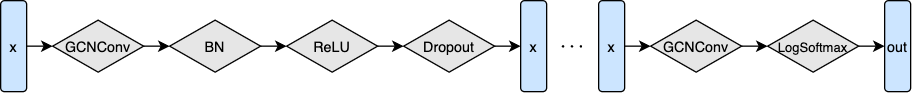

In [11]:
from torch.nn import BatchNorm1d
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    # TODO: Implement a function that initializes self.convs,
    # self.bns, and self.softmax.
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout, return_embeds=False):

        super(GCN, self).__init__()

        ############# Your code here ############
        ## Note:
        ## 0. Add a sanity check concerning the number of layers
        ## 1. You should use torch.nn.ModuleList for self.convs and self.bns
        ## 2. self.convs has num_layers GCNConv layers
        ## 3. self.bns has num_layers - 1 BatchNorm1d layers
        ## 4. You should use torch.nn.LogSoftmax for self.softmax
        ## 5. The parameters you can set for GCNConv include 'in_channels' and
        ## 'out_channels'. For more information please refer to the documentation:
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
        ## 6. The only parameter you need to set for BatchNorm1d is 'num_features'
        ## For more information please refer to the documentation:
        ## https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html

        # A list of GCNConv layers
        self.convs = torch.nn.ModuleList([GCNConv(input_dim, hidden_dim)])
        self.convs = self.convs.extend([GCNConv(hidden_dim, hidden_dim) for _ in range(num_layers - 2)])
        self.convs = self.convs.append(GCNConv(hidden_dim, output_dim))

        # A list of 1D batch normalization layers
        self.bns = torch.nn.ModuleList([BatchNorm1d(hidden_dim) for _ in range(num_layers - 1)])

        # The log softmax layer
        self.softmax = torch.nn.LogSoftmax()

        #########################################

        # Probability of an element getting zeroed
        self.dropout = dropout

        # Skip classification layer and return node embeddings
        self.return_embeds = return_embeds

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    # TODO: Implement a function that takes the feature tensor x and
    # edge_index tensor adj_t and returns the output tensor as
    # shown in the figure.
    def forward(self, x, edge_index):

        ############# Your code here ############
        ## Note:
        ## 1. Construct the network as shown in the figure
        ## 2. torch.nn.functional.relu and torch.nn.functional.dropout are useful
        ## For more information please refer to the documentation:
        ## https://pytorch.org/docs/stable/nn.functional.html
        ## 3. Don't forget to set F.dropout training to self.training
        ## 4. If return_embeds is True, then skip the last softmax layer

        for i, conv in enumerate(self.bns):
            conv_out = self.convs[i](x, edge_index)
            norm = self.bns[i](conv_out)
            x = F.relu(norm)
            x = F.dropout(x, self.dropout, training=self.training)
        
        if self.return_embeds:
            out = x
        else:
            out = self.convs[-1](x, edge_index)
            out = self.softmax(out)
        
        #########################################

        return out

In [24]:
# TODO: Implement a function that trains the model by
# using the given optimizer and loss_fn.
def train(model, data, train_idx, optimizer, loss_fn):
    model.train()

    ############# Your code here ############
    ## Note:
    ## 1. Zero grad the optimizer
    ## 2. Feed the data into the model
    ## 3. Slice the model output and label by train_idx
    ## 4. Feed the sliced output and label to loss_fn

    #########################################
    
    optimizer.zero_grad()
    out = model.forward(data.x, data.edge_index)
    out = out[train_idx]
    loss = loss_fn(out, data.y[train_idx].flatten(start_dim=0))

    loss.backward()
    optimizer.step()

    return loss.item()

In [13]:
# TODO: Implement a function that tests the model by
# using the given split_idx and evaluator.
@torch.no_grad()
def test(model, data, split_idx, evaluator, save_model_results=False):
    model.eval()

    ############# Your code here ############
    ## Note:
    ## 1. No index slicing here
    out = model.forward(data.x, data.edge_index)

    #########################################

    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': data.y[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': data.y[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': data.y[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    if save_model_results:
        print("Saving Model Predictions")

        data = {}
        data['y_pred'] = y_pred.view(-1).cpu().detach().numpy()

        df = pd.DataFrame(data=data)
        # Save locally as csv
        df.to_csv('ogbn-arxiv_node.csv', sep=',', index=False)

    return train_acc, valid_acc, test_acc

In [14]:
# Please do not change the args
args = {
    'device': device,
    'num_layers': 3,
    'hidden_dim': 256,
    'dropout': 0.5,
    'lr': 0.01,
    'epochs': 100,
}
args

{'device': 'cpu',
 'num_layers': 3,
 'hidden_dim': 256,
 'dropout': 0.5,
 'lr': 0.01,
 'epochs': 100}

In [15]:
model = GCN(data.num_features, args['hidden_dim'],
            dataset.num_classes, args['num_layers'],
            args['dropout']).to(device)
evaluator = Evaluator(name='ogbn-arxiv')


In [25]:
# Please do not change these args
# Training should take <10min using GPU runtime
import copy

# reset the parameters to initial random value
model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = F.nll_loss

best_model = None
best_valid_acc = 0

for epoch in range(1, 1 + args["epochs"]):
    loss = train(model, data, train_idx, optimizer, loss_fn)
    result = test(model, data, split_idx, evaluator)
    train_acc, valid_acc, test_acc = result
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model = copy.deepcopy(model)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 4.3184, Train: 19.43%, Valid: 25.94% Test: 23.52%
Epoch: 02, Loss: 2.7521, Train: 28.27%, Valid: 24.89% Test: 30.07%
Epoch: 03, Loss: 2.3539, Train: 21.22%, Valid: 12.35% Test: 11.46%
Epoch: 04, Loss: 2.1698, Train: 21.25%, Valid: 9.79% Test: 7.50%
Epoch: 05, Loss: 2.0258, Train: 24.61%, Valid: 13.32% Test: 10.78%
Epoch: 06, Loss: 1.9567, Train: 31.12%, Valid: 22.46% Test: 22.24%
Epoch: 07, Loss: 1.8899, Train: 37.81%, Valid: 32.83% Test: 35.41%
Epoch: 08, Loss: 1.8220, Train: 41.71%, Valid: 38.76% Test: 42.35%
Epoch: 09, Loss: 1.7856, Train: 43.04%, Valid: 41.11% Test: 44.74%
Epoch: 10, Loss: 1.7517, Train: 43.47%, Valid: 42.13% Test: 45.90%
Epoch: 11, Loss: 1.7176, Train: 44.27%, Valid: 44.23% Test: 48.10%
Epoch: 12, Loss: 1.7054, Train: 44.57%, Valid: 44.79% Test: 48.32%
Epoch: 13, Loss: 1.6819, Train: 45.53%, Valid: 45.66% Test: 48.83%
Epoch: 14, Loss: 1.6543, Train: 46.72%, Valid: 46.42% Test: 49.36%
Epoch: 15, Loss: 1.6385, Train: 47.82%, Valid: 46.90% Test: 49.8

## Question 5: What are your `best_model` validation and test accuracies?

Run the cell below to see the results of your best of model. Mark the results.

In [26]:
best_result = test(best_model, data, split_idx, evaluator, save_model_results=False)
train_acc, valid_acc, test_acc = best_result
print(f'Best model: '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Best model: Train: 66.53%, Valid: 65.61% Test: 66.43%


### Answer 5: 

Best model: Train: 66.53%, Valid: 65.61% Test: 66.43%

## Question 6: What happens if you remove the ReLu and Dropout layer from the GNN model?

### Answer 6: 

Your answer

## Question 7: Exchange the GCN layer with GATv2 and GraphSage. What gives you the best result?

### Answer 7: 

Your answer

# 4) GNN: Graph Property Prediction

In this section we will create a graph neural network for graph property prediction (graph classification).


In [27]:
from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
from torch_geometric.data import DataLoader
from tqdm.notebook import tqdm

# Load the dataset
dataset = PygGraphPropPredDataset(name='ogbg-molhiv')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: {}'.format(device))

split_idx = dataset.get_idx_split()

# Check task type
print('Task type: {}'.format(dataset.task_type))

Downloaded 0.00 GB: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]
Processing...


Extracting dataset/hiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 41127/41127 [00:02<00:00, 18055.82it/s]


Converting graphs into PyG objects...


100%|██████████| 41127/41127 [00:08<00:00, 4745.04it/s]


Saving...
Device: cpu
Task type: binary classification


Done!


In [28]:
# Load the dataset splits into corresponding dataloaders
# We will train the graph classification task on a batch of 32 graphs
# Shuffle the order of graphs for training set
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=32, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset[split_idx["test"]], batch_size=32, shuffle=False, num_workers=0)

/home/felix/.conda/envs/graphml/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [29]:
# Please do not change the args
args = {
    'device': device,
    'num_layers': 5,
    'hidden_dim': 256,
    'dropout': 0.5,
    'lr': 0.001,
    'epochs': 30,
}
args

{'device': 'cpu',
 'num_layers': 5,
 'hidden_dim': 256,
 'dropout': 0.5,
 'lr': 0.001,
 'epochs': 30}

## Graph Prediction Model

### Graph Mini-Batching
Before diving into the actual model, we introduce the concept of mini-batching with graphs. In order to parallelize the processing of a mini-batch of graphs, PyG combines the graphs into a single disconnected graph data object (*torch_geometric.data.Batch*). *torch_geometric.data.Batch* inherits from *torch_geometric.data.Data* (introduced earlier) and contains an additional attribute called `batch`.

The `batch` attribute is a vector mapping each node to the index of its corresponding graph within the mini-batch:

    batch = [0, ..., 0, 1, ..., n - 2, n - 1, ..., n - 1]

This attribute is crucial for associating which graph each node belongs to and can be used to e.g. average the node embeddings for each graph individually to compute graph level embeddings.



### Implemention
Now, we have all of the tools to implement a GCN Graph Prediction model!  

We will reuse the existing GCN model to generate `node_embeddings` and then use  `Global Pooling` over the nodes to create graph level embeddings that can be used to predict properties for the each graph. Remember that the `batch` attribute will be essential for performining Global Pooling over our mini-batch of graphs.

In [34]:
from torch_geometric.nn import global_mean_pool
from ogb.graphproppred.mol_encoder import AtomEncoder


### GCN to predict graph property
class GCN_Graph(torch.nn.Module):
    def __init__(self, hidden_dim, output_dim, num_layers, dropout):
        super(GCN_Graph, self).__init__()

        # Load encoders for Atoms in molecule graphs
        self.node_encoder = AtomEncoder(hidden_dim)

        # Node embedding model
        # Note that the input_dim and output_dim are set to hidden_dim
        self.gnn_node = GCN(hidden_dim, hidden_dim,
                            hidden_dim, num_layers, dropout, return_embeds=True)

        self.pool = None

        ############# Your code here ############
        ## Note:
        ## 1. Initialize self.pool as a global mean pooling layer
        ## For more information please refer to the documentation:
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#global-pooling-layers
        self.pool = global_mean_pool

        #########################################

        # Output layer
        self.linear = torch.nn.Linear(hidden_dim, output_dim)

    def reset_parameters(self):
        self.gnn_node.reset_parameters()
        self.linear.reset_parameters()

    # TODO: Implement a function that takes as input a
    # mini-batch of graphs (torch_geometric.data.Batch) and
    # returns the predicted graph property for each graph.
    #
    # NOTE: Since we are predicting graph level properties,
    # your output will be a tensor with dimension equaling
    # the number of graphs in the mini-batch
    def forward(self, batched_data):
        # Extract important attributes of our mini-batch
        x, edge_index, batch = batched_data.x, batched_data.edge_index, batched_data.batch
        embed = self.node_encoder(x)

        ############# Your code here ############
        ## Note:
        ## 1. Construct node embeddings using existing GCN model
        ## 2. Use the global pooling layer to aggregate features for each individual graph
        ## For more information please refer to the documentation:
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#global-pooling-layers
        ## 3. Use a linear layer to predict each graph's property
        embed = self.gnn_node(embed, edge_index)
        pooled = self.pool(embed, batch)
        out = self.linear(pooled)

        #########################################

        return out

In [31]:
# TODO: Implement a function that trains your model by
# using the given optimizer and loss_fn.
def train(model, device, data_loader, optimizer, loss_fn):
    model.train()
    loss = 0

    for step, batch in enumerate(tqdm(data_loader, desc="Iteration")):
        batch = batch.to(device)
        if batch.x.shape[0] == 1 or batch.batch[-1] == 0:
            pass
        else:
            ## ignore nan targets (unlabeled) when computing training loss.
            is_labeled = batch.y == batch.y

            ############# Your code here ############
            ## Note:
            ## 1. Zero grad the optimizer
            ## 2. Feed the data into the model
            ## 3. Use `is_labeled` mask to filter output and labels
            ## 4. You may need to change the type of label to torch.float32
            ## 5. Feed the output and label to the loss_fn

            #########################################
            
            optimizer.zero_grad()
            out = model.forward(batch)
            out = out[is_labeled]
            label = batch.y[is_labeled].float()
            loss = loss_fn(out, label)

            loss.backward()
            optimizer.step()

    return loss.item()

In [32]:
# The evaluation function
def eval(model, device, loader, evaluator, save_model_results=False, save_file=None):
    model.eval()
    y_true = []
    y_pred = []

    for step, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(device)

        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(batch)

            y_true.append(batch.y.view(pred.shape).detach().cpu())
            y_pred.append(pred.detach().cpu())

    y_true = torch.cat(y_true, dim=0).numpy()
    y_pred = torch.cat(y_pred, dim=0).numpy()

    input_dict = {"y_true": y_true, "y_pred": y_pred}

    if save_model_results:
        print("Saving Model Predictions")

        # Create a pandas dataframe with a two columns
        # y_pred | y_true
        data = {}
        data['y_pred'] = y_pred.reshape(-1)
        data['y_true'] = y_true.reshape(-1)

        df = pd.DataFrame(data=data)
        # Save to csv
        df.to_csv('ogbg-molhiv_graph_' + save_file + '.csv', sep=',', index=False)

    return evaluator.eval(input_dict)

In [35]:
model = GCN_Graph(args['hidden_dim'],
                  dataset.num_tasks, args['num_layers'],
                  args['dropout']).to(device)
evaluator = Evaluator(name='ogbg-molhiv')

In [36]:
# Please do not change these args
# Training should take <10min using GPU runtime
import copy

model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = torch.nn.BCEWithLogitsLoss()

best_model = None
best_valid_acc = 0

for epoch in range(1, 1 + args["epochs"]):
    print('Training...')
    loss = train(model, device, train_loader, optimizer, loss_fn)

    print('Evaluating...')
    train_result = eval(model, device, train_loader, evaluator)
    val_result = eval(model, device, valid_loader, evaluator)
    test_result = eval(model, device, test_loader, evaluator)

    train_acc, valid_acc, test_acc = train_result[dataset.eval_metric], val_result[dataset.eval_metric], test_result[
        dataset.eval_metric]
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model = copy.deepcopy(model)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')

Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 01, Loss: 0.0330, Train: 72.25%, Valid: 67.24% Test: 68.34%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 02, Loss: 0.0368, Train: 75.60%, Valid: 72.45% Test: 70.51%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Question 8: What are your `best_model` validation and test ROC-AUC scores?

Run the cell below to see the results of your best of model and save your model's predictions over the validation and test datasets.

In [ ]:
train_acc = eval(best_model, device, train_loader, evaluator)[dataset.eval_metric]
valid_acc = eval(best_model, device, valid_loader, evaluator, save_model_results=False, save_file="valid")[
    dataset.eval_metric]
test_acc = eval(best_model, device, test_loader, evaluator, save_model_results=False, save_file="test")[
    dataset.eval_metric]

print(f'Best model: '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

### Answer 8:

Your answer

## Question 9: What is the role of `torch.nn.Linear` in the model?

### Answer 9:

Your answer